In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from collections import defaultdict

from keras import backend as K
from keras.datasets import mnist
from keras.layers import Dense
from keras.models import Sequential 
from keras.utils import plot_model
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold, train_test_split

In [2]:
(images_train, labels_train), (images_valid, labels_valid) = mnist.load_data()

In [3]:
num_train, img_height, img_width = images_train.shape
num_valid, _, _ = images_valid.shape
num_features = img_height * img_width

labels = np.unique(labels_train)
num_labels = len(labels)

Image label: 5


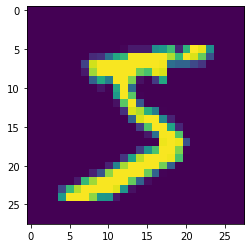

In [4]:
plt.imshow(images_train[0, :, :])
print(f"Image label: {labels_train[0]}")

In [5]:
images_train_normed = images_train.reshape(num_train, -1) / 255.0
images_valid_normed = images_valid.reshape(num_valid, -1) / 255.0

In [6]:
labels_train_onehot = pd.get_dummies(labels_train).values
labels_valid_onehot = pd.get_dummies(labels_valid).values

In [7]:
images_train_split_normed, images_test_split_normed, labels_train_split_onehot, labels_test_split_onehot = \
    train_test_split(images_train_normed, labels_train_onehot, test_size=0.25, random_state=42)

In [8]:
print(f"# of labels: {num_labels}")
print(f"# of training samples: {images_train_split_normed.shape[0]}")

# of labels: 10
# of training samples: 45000


In [9]:
images_train_normed.shape

(60000, 784)

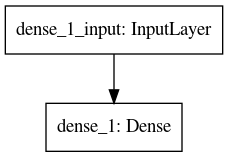

In [10]:
logit_model = Sequential() 
logit_model.add(Dense(num_labels, input_dim=num_features, activation='softmax')) 
logit_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
plot_model(logit_model)

In [11]:
weights = logit_model.get_weights()
logit_model.set_weights(np.random.permutation(weights))

In [12]:
kfolds_five = KFold(n_splits=5)

kfolds_acc = []
kfolds_loss = []
for train_split_idx, test_split_idx in kfolds_five.split(images_train_normed):
    logit_model.fit(images_train_normed[train_split_idx],
              labels_train_onehot[train_split_idx],
              epochs=12)
    
    loss, acc = logit_model.evaluate(x=images_train_normed[test_split_idx], y=labels_train_onehot[test_split_idx])    
    kfolds_loss.append(loss)
    kfolds_acc.append(acc)
    
    logit_model.set_weights([np.random.permutation(w.flat).reshape(w.shape) for w in logit_model.get_weights()])


Epoch 1/12
48000/48000 [==============================] - 1s 27us/step - loss: 0.8449 - accuracy: 0.7996
Epoch 2/12
48000/48000 [==============================] - 1s 25us/step - loss: 0.4866 - accuracy: 0.8745
Epoch 3/12
48000/48000 [==============================] - 1s 25us/step - loss: 0.4258 - accuracy: 0.8864
Epoch 4/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3956 - accuracy: 0.8925
Epoch 5/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3765 - accuracy: 0.8965
Epoch 6/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3631 - accuracy: 0.9004
Epoch 7/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3529 - accuracy: 0.9026
Epoch 8/12
48000/48000 [==============================] - 1s 25us/step - loss: 0.3449 - accuracy: 0.9047
Epoch 9/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3382 - accuracy: 0.9066
Epoch 10/12
48000/48000 [==============================

In [13]:
logit_model.fit(images_train_normed[train_split_idx],
              labels_train_onehot[train_split_idx],
              epochs=12)

Epoch 1/12
48000/48000 [==============================] - 1s 26us/step - loss: 1.0132 - accuracy: 0.6806
Epoch 2/12
48000/48000 [==============================] - 1s 24us/step - loss: 0.5399 - accuracy: 0.8442
Epoch 3/12
48000/48000 [==============================] - 1s 27us/step - loss: 0.4622 - accuracy: 0.8684
Epoch 4/12
48000/48000 [==============================] - 1s 25us/step - loss: 0.4250 - accuracy: 0.8795
Epoch 5/12
48000/48000 [==============================] - 1s 24us/step - loss: 0.4018 - accuracy: 0.8859
Epoch 6/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3855 - accuracy: 0.8910
Epoch 7/12
48000/48000 [==============================] - 1s 25us/step - loss: 0.3735 - accuracy: 0.8947
Epoch 8/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3639 - accuracy: 0.8974
Epoch 9/12
48000/48000 [==============================] - 1s 26us/step - loss: 0.3560 - accuracy: 0.8998
Epoch 10/12
48000/48000 [==============================

In [14]:
valid_loss, valid_acc = logit_model.evaluate(x=images_valid_normed, y=labels_valid_onehot)

10000/10000 [==============================] - 0s 11us/step


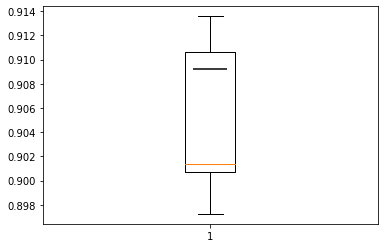

In [15]:
plt.boxplot(kfolds_acc)
plt.hlines(y=valid_acc, xmin=0.95, xmax=1.05)

In [16]:
labels_valid_fitted_probs = logit_model.predict_proba(x=images_valid_normed)
roc_auc = roc_auc_score(labels_valid_onehot,
                        labels_valid_fitted_probs,
                        multi_class="ovr",
                        average="macro")
roc_auc

0.9919687278809816

In [17]:
labels_confusion = defaultdict(dict)

for label, labels_valid_fitted_prob in zip(labels_valid, labels_valid_fitted_probs):
    if label in labels_confusion:
        labels_confusion[label]["prob"] += labels_valid_fitted_prob
        labels_confusion[label]["count"] += 1
    else:
        labels_confusion[label]["prob"] = labels_valid_fitted_prob
        labels_confusion[label]["count"] = 1

labels_confusion_prob = np.array([
    labels_confusion[label]["prob"] / labels_confusion[label]["count"]
    for label in labels
])

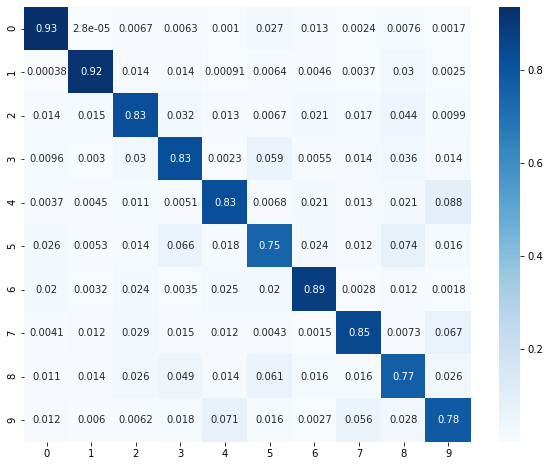

In [18]:
plt.figure(figsize=(10, 8))
sns.heatmap(labels_confusion_prob, annot=True, cmap="Blues")

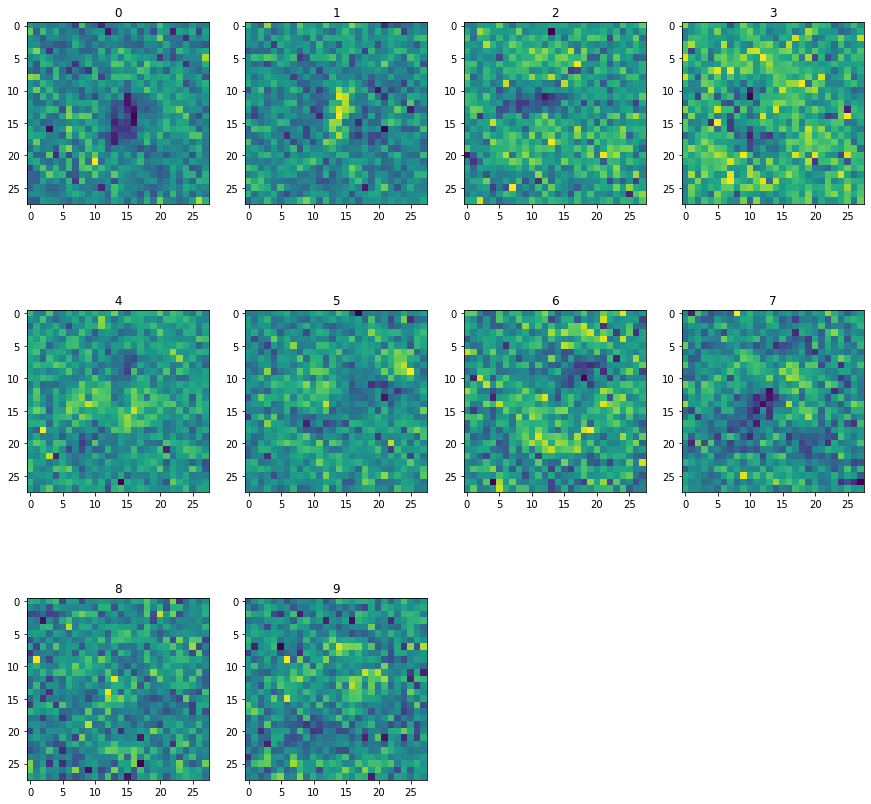

In [19]:
plt.figure(figsize=(15, 15))
for label in range(num_labels):
    plt.subplot(3, 4, label + 1)
    plt.imshow(logit_model.get_weights()[0][:,label].reshape(img_height, img_width))
    plt.title(label)

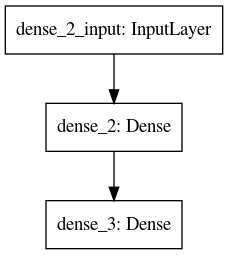

In [20]:
mlp_model = Sequential()
mlp_model.add(Dense(100, input_dim=num_features, activation='relu')) 
mlp_model.add(Dense(num_labels, input_dim=100, activation='softmax')) 
mlp_model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
plot_model(mlp_model)

In [ ]:
kfolds_five = KFold(n_splits=5)

kfolds_acc = []
kfolds_loss = []
for train_split_idx, test_split_idx in kfolds_five.split(images_train_normed):
    mlp_model.fit(images_train_normed[train_split_idx],
              labels_train_onehot[train_split_idx],
              epochs=12);
    
    loss, acc = mlp_model.evaluate(x=images_train_normed[test_split_idx], y=labels_train_onehot[test_split_idx])    
    kfolds_loss.append(loss)
    kfolds_acc.append(acc)
    
    mlp_model.set_weights([np.random.permutation(w.flat).reshape(w.shape) for w in mlp_model.get_weights()])

Epoch 1/12
48000/48000 [==============================] - 2s 39us/step - loss: 0.1030 - accuracy: 0.9709
Epoch 2/12
48000/48000 [==============================] - 2s 38us/step - loss: 0.0982 - accuracy: 0.9732
Epoch 3/12
48000/48000 [==============================] - 2s 37us/step - loss: 0.0942 - accuracy: 0.9742
Epoch 4/12
48000/48000 [==============================] - 2s 38us/step - loss: 0.0904 - accuracy: 0.9755
Epoch 5/12
48000/48000 [==============================] - 2s 39us/step - loss: 0.0870 - accuracy: 0.9765
Epoch 6/12
48000/48000 [==============================] - 2s 37us/step - loss: 0.0837 - accuracy: 0.9776
Epoch 7/12
48000/48000 [==============================] - 2s 39us/step - loss: 0.0806 - accuracy: 0.9785
Epoch 8/12
48000/48000 [==============================] - 2s 41us/step - loss: 0.0778 - accuracy: 0.9797
Epoch 9/12
48000/48000 [==============================] - 3s 54us/step - loss: 0.0752 - accuracy: 0.9801
Epoch 10/12
48000/48000 [==============================

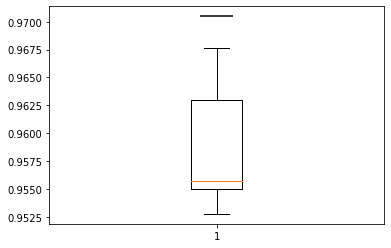

In [37]:
mlp_model.fit(images_train_normed[train_split_idx],
              labels_train_onehot[train_split_idx],
              epochs=12)
valid_loss, valid_acc = mlp_model.evaluate(x=images_valid_normed, y=labels_valid_onehot)

plt.boxplot(kfolds_acc)
plt.hlines(y=valid_acc, xmin=0.95, xmax=1.05)

In [23]:
labels_valid_fitted_probs = mlp_model.predict_proba(x=images_valid_normed)
roc_auc = roc_auc_score(labels_valid_onehot,
                        labels_valid_fitted_probs,
                        multi_class="ovr",
                        average="macro")
roc_auc

0.9987759191311772

In [24]:
labels_confusion = defaultdict(dict)

for label, labels_valid_fitted_prob in zip(labels_valid, labels_valid_fitted_probs):
    if label in labels_confusion:
        labels_confusion[label]["prob"] += labels_valid_fitted_prob
        labels_confusion[label]["count"] += 1
    else:
        labels_confusion[label]["prob"] = labels_valid_fitted_prob
        labels_confusion[label]["count"] = 1

labels_confusion_prob = np.array([
    labels_confusion[label]["prob"] / labels_confusion[label]["count"]
    for label in labels
])

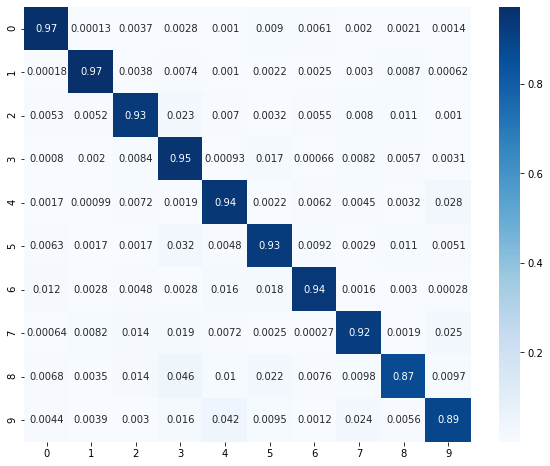

In [25]:
plt.figure(figsize=(10, 8))
sns.heatmap(labels_confusion_prob, annot=True, cmap="Blues")

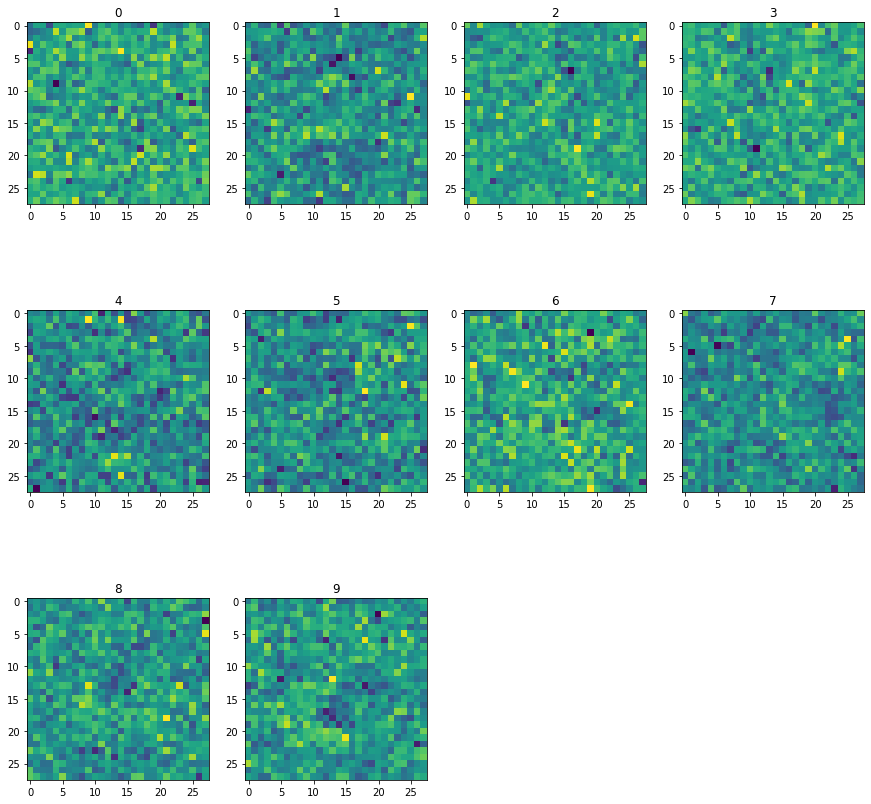

In [26]:
plt.figure(figsize=(15, 15))
for label in range(num_labels):
    plt.subplot(3, 4, label + 1)
    plt.imshow(mlp_model.get_weights()[0][:,label].reshape(img_height, img_width))
    plt.title(label)

In [60]:
preds_valid = mlp_model.predict(images_valid_normed)
#model.output[:, np.argmax(preds[0])
mlp_model.output[:, np.argmax(preds_valid[0])]

<tf.Tensor 'strided_slice:0' shape=(None,) dtype=float32>

In [63]:
K.gradients(K.categorical_crossentropy, )